In [1]:
import tkinter as tk
import tkinter.ttk as ttk
from tkinter import filedialog as fd
import tkinter.simpledialog
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sn

df = None
df_saved = None

In [2]:
def open_data():
    global df;
    file_name = fd.askopenfile()
    df = pd.read_csv(file_name, sep=',')
    refresh()
def save_data():
    file_name = fd.asksaveasfile()
    df.to_csv(file_name, index = False, line_terminator='\n')    
def add_data():
    global df;
    row = tk.simpledialog.askstring("Adding row", "Enter line of data with \',\': ")
    row = row.split(",")
    target_len = len(list(df.columns))
    if target_len > len(row):
        row = row[:target_len] + [0] * (target_len - len(row))
    df.loc[len(df)] = row
    refresh()
def del_data():
    dialog = tk.Toplevel()
    dialog.title('Delete')
    width = 200
    height = 75
    x = root.winfo_screenwidth() // 2 - width // 2
    y = root.winfo_screenheight() // 2 - height // 2
    dialog.geometry('{}x{}+{}+{}'.format(width, height, x, y))
    dialog.text = tk.Entry(dialog, borderwidth = 0)
    dialog.text.place(x=50, y=0, width=100)
    dialog.text.focus()
    dialog.button = tk.Button(dialog, text='Ok', borderwidth = 1, command=lambda: del_row(int(dialog.text.get())))
    dialog.button.place(x=50, y=25, width=100)
def del_row(row):
    global df;
    df = df.drop(row)
    df["#"] = np.arange(len(df))
    refresh()

def sort_data():
    global df, df_saved
    column = tk.simpledialog.askstring("Sorting", "Enter column for sorting: ")
    if df_saved is None:
        df_saved = df
    try:
        df = df.sort_values(column)
        info_label.config(text="Sorting is done")
    except KeyError:
        info_label.config(text="Unkhown name of the column")
    refresh()

def select_data():
    global df, df_saved
    column = tk.simpledialog.askstring("Selection", "Enter column for selecting: ")
    threshold = tk.simpledialog.askstring("Selection", "Enter threshold: ")
    relation = tk.simpledialog.askstring("Selection", "Enter relation (<, >, =): ")
    try:
        if df[column].dtypes == "float64":
            threshold = float(threshold)
        elif(df[column].dtypes == "int64"):
            threshold = int(threshold)
        if relation == '>' or relation == '<' or relation == '=':
            if df_saved is None:
                df_saved = df
            info_label.config(text="Selection is done")
        if relation == '>':
            df = df.loc[df[column] > threshold]
        if relation == '<':
            df = df.loc[df[column] < threshold]
        if relation == '=':
            df = df.loc[df[column] == threshold]
        refresh()
    except KeyError:
        info_label.config(text="Error in select attribute")

def cancel():
    global df, df_saved
    if df_saved is not None:
        df = df_saved
        df_saved = None
        info_label.config(text="All is Ok")
        refresh()    
    
def refresh():
    try:
        data_tab.tbl.destroy()
    except AttributeError:
        pass
    data_tab.tbl = tk.Frame(data_tab)
    headings = list(df.columns)
    attributes_number = len(headings)
    columns = list(range(attributes_number))
    data_tab.tbl.tree = ttk.Treeview(data_tab.tbl, show="headings", columns=columns)
    for i in range(attributes_number):
        data_tab.tbl.tree.heading(i, text=headings[i])
        data_tab.tbl.tree.column(i, minwidth=0, width=100)
    data_tab.tbl.ysb = ttk.Scrollbar(data_tab.tbl, orient="vertical",command=data_tab.tbl.tree.yview)
    data_tab.tbl.xsb = ttk.Scrollbar(data_tab.tbl, orient="horizontal",command=data_tab.tbl.tree.xview)
    data_tab.tbl.tree.configure(yscroll=data_tab.tbl.ysb.set,xscroll=data_tab.tbl.xsb.set)
    for i in range(df.shape[0]):
        data_tab.tbl.tree.insert("", "end", values=list(df.iloc[i]))
    data_tab.tbl.tree.grid(row=0, column=0, sticky="ns")
    data_tab.tbl.ysb.grid(row=0, column=1, sticky="ns")
    data_tab.tbl.xsb.grid(row=1, column=0, sticky="ew")
    data_tab.tbl.rowconfigure(0, weight=1)
    data_tab.tbl.columnconfigure(0, weight=1)
    data_tab.tbl.pack(side='bottom', fill='both', expand=1) 
def draw_bar():
    try:
        graph_tab.figure.canvas.get_tk_widget().destroy()
    except AttributeError:
        pass
    global df
    column = tk.simpledialog.askstring("Bar plot", "Enter name of column for visualization: ")
    values = pd.unique(df['Age'])
    values.sort()
    num_rows = df.shape[0]
    male_mean = values * [0.0]
    female_mean = values * [0.0]
    for i in range(len(values)):
        indices = [j for j in range(num_rows) if (df['Age'][j] == values[i] and df['Gender'][j] == 'Male')]
        male_mean[i] = np.mean(df[column][indices]) if (len(indices) > 0) else 0
        indices = [j for j in range(num_rows) if (df['Age'][j] == values[i] and df['Gender'][j] == 'Female')]
        female_mean[i] = np.mean(df[column][indices]) if (len(indices) > 0) else 0
    df2 = pd.DataFrame({'Male' : male_mean, 'Female' : female_mean})
    
    graph_tab.figure = plt.Figure(figsize = (6, 5))
    graph_tab.figure.ax = graph_tab.figure.add_subplot(111)
    graph_tab.figure.canvas = FigureCanvasTkAgg(graph_tab.figure, graph_tab)
    graph_tab.figure.canvas.get_tk_widget().pack(side='top', fill='x')
    df2.plot(kind='bar', ax=graph_tab.figure.ax, legend = True)
    
    x = np.arange(len(values))
    graph_tab.figure.ax.set_xticks(x, values)
    graph_tab.figure.ax.legend()
def draw_line():
    try:
        graph_tab.figure.canvas.get_tk_widget().destroy()
    except AttributeError:
        pass
    global df
    x_column = tk.simpledialog.askstring("Line plot", "Enter name of column for x: ")
    y_column = tk.simpledialog.askstring("Line plot", "Enter name of column for y: ")
    graph_tab.figure = plt.Figure(figsize = (6, 5))
    graph_tab.figure.ax = graph_tab.figure.add_subplot(111)
    graph_tab.figure.canvas = FigureCanvasTkAgg(graph_tab.figure, graph_tab)
    graph_tab.figure.canvas.get_tk_widget().pack(side='top', fill='x')
    df2 = df[[x_column, y_column]].groupby(x_column).mean()
    df2.plot(kind='line', ax=graph_tab.figure.ax, legend = True)
    

def draw_scatter():
    try:
        graph_tab.figure.canvas.get_tk_widget().destroy()
    except AttributeError:
        pass
    global df
    x_column = tk.simpledialog.askstring("Scatter plot", "Enter name of column for x: ")
    y_column = tk.simpledialog.askstring("Scatter plot", "Enter name of column for y: ")
    c_column = tk.simpledialog.askstring("Scatter plot", "Enter name of column for color: ")
    graph_tab.figure = plt.Figure(figsize = (6, 5))
    graph_tab.figure.ax = graph_tab.figure.add_subplot(111)
    graph_tab.figure.ax.scatter(df[x_column] + np.random.uniform(-0.3, +0.3, df.shape[0]),
                                df[y_column] + np.random.uniform(-0.3, +0.3, df.shape[0]),
                                c=df[c_column], alpha = 0.3, cmap='turbo')
    graph_tab.figure.canvas = FigureCanvasTkAgg(graph_tab.figure, graph_tab)
    graph_tab.figure.canvas.get_tk_widget().pack(side='top', fill='x')
def draw_corr():
    try:
        graph_tab.figure.canvas.get_tk_widget().destroy()
    except AttributeError:
        pass
    global df
    graph_tab.figure = plt.Figure(figsize = (8, 8))
    graph_tab.figure.ax = graph_tab.figure.add_subplot(111)
    sn.heatmap(df.corr(), square=True, ax=graph_tab.figure.ax)
    graph_tab.figure.canvas = FigureCanvasTkAgg(graph_tab.figure, graph_tab)
    graph_tab.figure.canvas.get_tk_widget().pack(side='top', fill='x')
    plt.setp(graph_tab.figure.ax.xaxis.get_majorticklabels(), rotation = 45)
    plt.setp(graph_tab.figure.ax.yaxis.get_majorticklabels(), rotation = 45)



In [3]:
root = tk.Tk()
tab_control = ttk.Notebook(root)
info_label = tk.Label(root, fg="white", bg="black", text='All is ok')

data_tab = ttk.Frame(tab_control)
tab_control.add(data_tab, text='Data Processing')
data_frame = ttk.Frame(data_tab)
data_tab.bopen = tk.Button(data_frame, bg="#C4FFB7", text='Open', command=open_data)
data_tab.bsave = tk.Button(data_frame, bg="#D7D3F3", text='Save', command=save_data)
data_tab.badd = tk.Button(data_frame, bg="#D7D7D7", text='Add row', command=add_data)
data_tab.bdel = tk.Button(data_frame, bg="#F76767", text='Delete row', command=del_data)
data_tab.bsort = tk.Button(data_frame, bg="#D7D7D7", text='Sort', command=sort_data)
data_tab.bsel = tk.Button(data_frame, bg="#D7D7D7", text='Select', command=select_data)
data_tab.bcan = tk.Button(data_frame, bg="#F76767", text='Cancel', command=cancel)

data_frame.pack(side='top', fill='x')
data_tab.bopen.pack(side='left', fill='x')
data_tab.bsave.pack(side='left', fill='x')
data_tab.badd.pack(side='left', fill='x')
data_tab.bdel.pack(side='left', fill='x')
data_tab.bsort.pack(side='left', fill='x')
data_tab.bsel.pack(side='left', fill='x')
data_tab.bcan.pack(side='left', fill='x')

graph_tab = ttk.Frame(tab_control)
tab_control.add(graph_tab, text='Visualization')
graph_frame = ttk.Frame(graph_tab)
graph_tab.bbar = tk.Button(graph_frame, text='Bar', command=draw_bar)
graph_tab.bline = tk.Button(graph_frame, text='Line', command=draw_line)
graph_tab.bscat = tk.Button(graph_frame, text='Scatter', command=draw_scatter)
graph_tab.bcorr = tk.Button(graph_frame, text='Correlation', command=draw_corr)


graph_frame.pack(side='top', fill='x')
graph_tab.bbar.pack(side='left', fill='x')
graph_tab.bline.pack(side='left', fill='x')
graph_tab.bscat.pack(side='left', fill='x')
graph_tab.bcorr.pack(side='left', fill='x')


ai_tab = ttk.Frame(tab_control)
tab_control.add(ai_tab, text='Artificial Intelligence')

tab_control.pack(expand=1, fill='both')
info_label.pack(side='bottom', fill='x')

root.title('Sleep Dependence On Age')
width = 600
height = 400
x = root.winfo_screenwidth() // 2 - width // 2
y = root.winfo_screenheight() // 2 - height // 2
root.geometry('{}x{}+{}+{}'.format(width, height, x, y))
root.mainloop()

KeyboardInterrupt: 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv("Sleep_Efficiency.csv", sep=',')
x = df.loc[:, df.columns]
y = df.loc[:, 'Sleep_efficiency']
df.describe(include='all')

,Age,Gender,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Smoking_status,Exercise_frequency
count,439.000000,439,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439,439.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
freq,NaN,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288,NaN
mean,40.507973,NaN,7.453303,0.793235,22.685649,53.216401,24.097950,1.576310,23.348519,1.164009,NaN,1.799544
std,12.524289,NaN,0.867070,0.133704,3.512086,15.590979,15.107287,1.350793,29.913409,1.619087,NaN,1.422551
min,18.000000,NaN,5.000000,0.500000,15.000000,18.000000,7.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,29.000000,NaN,7.000000,0.710000,20.000000,52.500000,15.000000,1.000000,0.000000,0.000000,NaN,0.000000
50%,40.000000,NaN,7.500000,0.830000,22.000000,58.000000,18.000000,1.000000,25.000000,0.000000,NaN,2.000000
75%,52.000000,NaN,8.000000,0.900000,25.000000,63.000000,21.000000,3.000000,50.000000,2.000000,NaN,3.000000


In [2]:
x['Age'] = (x['Age'] - x['Age'].median()) / x['Age'].std()
x['Gender'] = (x['Gender'] == 'Male').astype(int)


x['Sleep_duration'] = x['Sleep_duration'] - x['Sleep_duration'].median()
x['REM_sleep_percentage'] = x['REM_sleep_percentage'] - x['REM_sleep_percentage'].median()
x['Deep_sleep percentage'] = (x['Deep_sleep percentage'] - x['Deep_sleep percentage'].median()) / x['Deep_sleep percentage'].std()
x['Light_sleep_percentage'] = (x['Light_sleep_percentage'] - x['Light_sleep_percentage'].median()) / x['Light_sleep_percentage'].std()
x['Caffeine_consumption'] = (x['Caffeine_consumption'] - x['Caffeine_consumption'].median()) / x['Caffeine_consumption'].std()
x['Smoking_status'] = (x['Smoking_status'] == 'No').astype(int)

x.drop(columns=['Sleep_efficiency'], inplace = True)

x.describe()

,Age,Gender,Sleep_duration,REM_sleep_percentage,Deep_sleep percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Smoking_status,Exercise_frequency
count,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,0.040559,0.510251,-0.046697,0.685649,-0.306818,0.403643,1.576310,-0.055209,1.164009,0.656036,1.799544
std,1.000000,0.500465,0.867070,3.512086,1.000000,1.000000,1.350793,1.000000,1.619087,0.475571,1.422551
min,-1.756587,0.000000,-2.500000,-7.000000,-2.565586,-0.728125,0.000000,-0.835746,0.000000,0.000000,0.000000
25%,-0.878293,0.000000,-0.500000,-2.000000,-0.352768,-0.198580,1.000000,-0.835746,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000
75%,0.958138,1.000000,0.500000,3.000000,0.320698,0.198580,3.000000,0.835746,2.000000,1.000000,3.000000
max,1.996121,1.000000,2.500000,8.000000,1.090374,2.978695,4.000000,5.850219,5.000000,1.000000,5.000000


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

In [4]:
from sklearn.linear_model import LinearRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.46, random_state = 42)
print("Train set: ", x_train.shape)
print("Test set: ", x_test.shape)
model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('rmse: %.3f, mae: %.3f' % (mse ** 0.5, mae))
print('Coefficients: \n', model.coef_)

Train set:  (237, 11)
Test set:  (202, 11)
rmse: 0.059, mae: 0.046
Coefficients: 
 [ 0.0073646   0.00066018  0.00504882  0.00465624  0.04390004 -0.0456138
 -0.03179059  0.00234608 -0.00541543  0.03911593  0.00600435]


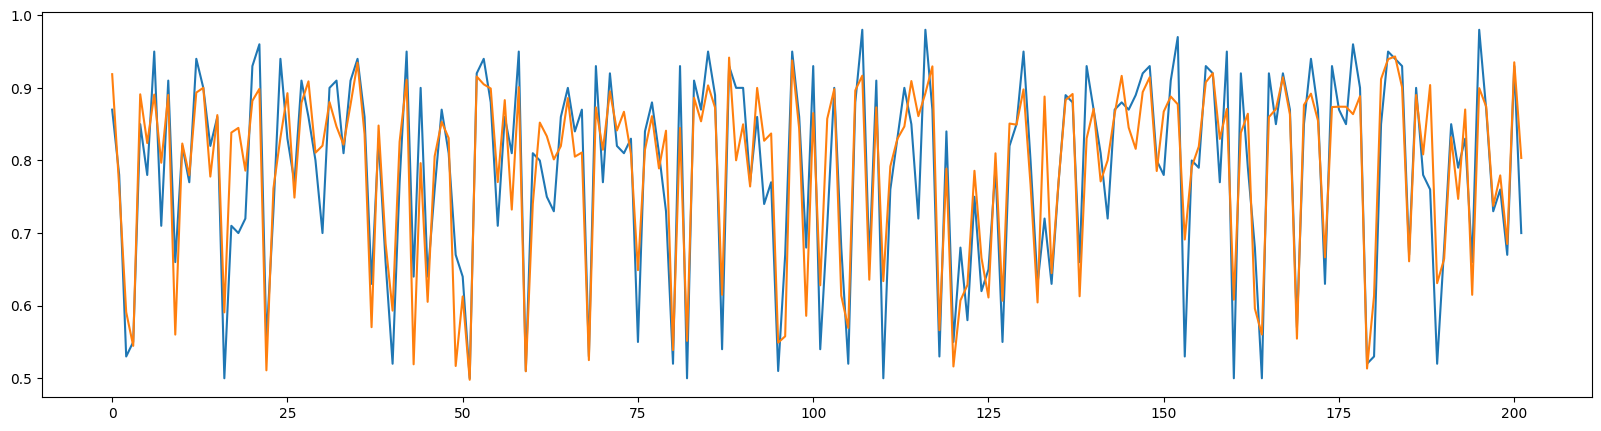

In [5]:
import numpy as np
fig, ax = plt.subplots()
line1 = ax.plot(np.asarray(y_test))
line2 = ax.plot(np.asarray(y_pred))
#line3 = ax.plot(np.sort(100 * abs(np.asarray(y_test) - np.asarray(y_pred))/ np.asarray(y_test)))
plt.show()

mse: 0.048, mae: 0.037


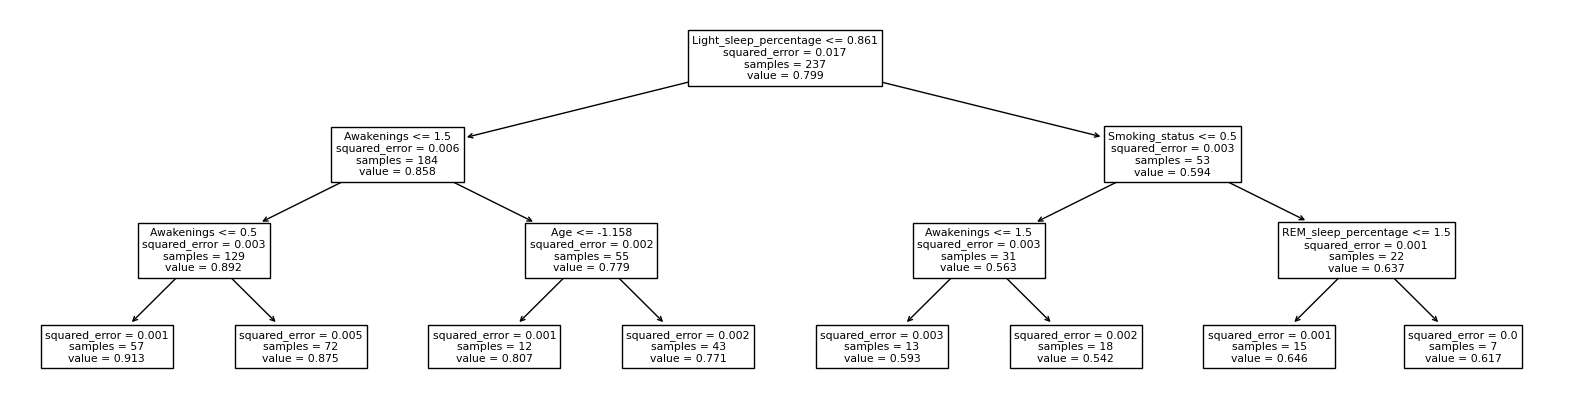

<Figure size 2000x1000 with 0 Axes>

In [6]:
from sklearn import tree
model = tree.DecisionTreeRegressor(max_depth=3, random_state=42).fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('mse: %.3f, mae: %.3f' % (mse ** 0.5, mae))
tree.plot_tree(model, feature_names=x.columns)
plt.figure(figsize=(20,10))
plt.show()

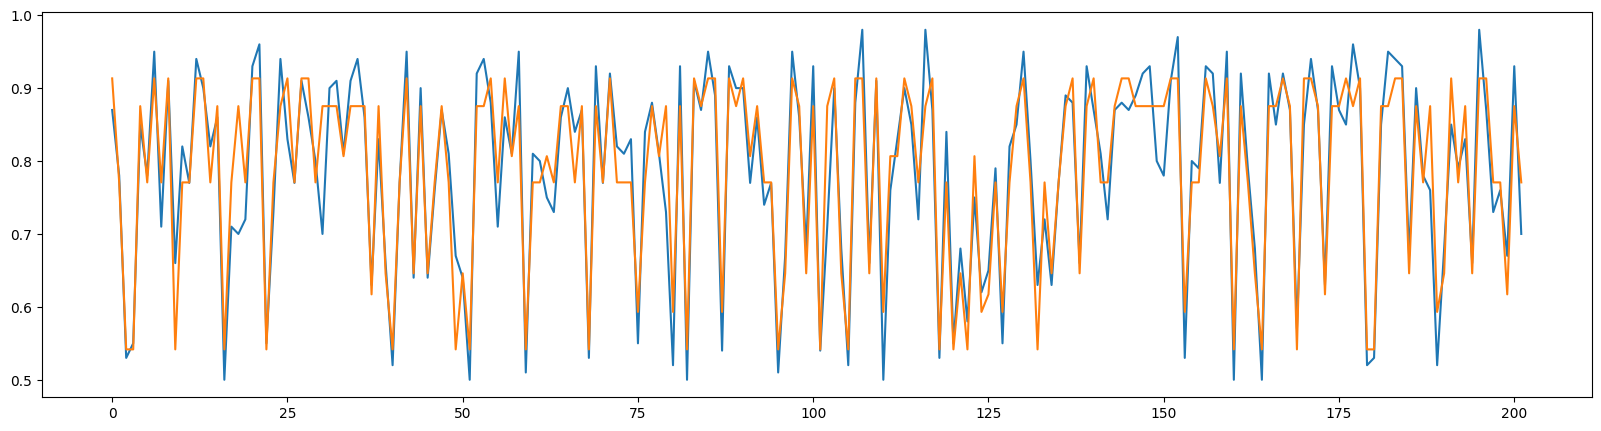

In [7]:
import numpy as np
fig, ax = plt.subplots()
line1 = ax.plot(np.asarray(y_test))
line2 = ax.plot(np.asarray(y_pred))
#line3 = ax.plot(np.sort(100 * abs(np.asarray(y_test) - np.asarray(y_pred))/ np.asarray(y_test)))
plt.show()

In [8]:
from sklearn import neighbors
model = neighbors.KNeighborsRegressor(5, weights='uniform').fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('mse: %.3f, mae: %.3f' % (mse ** 0.5, mae))

mse: 0.067, mae: 0.049


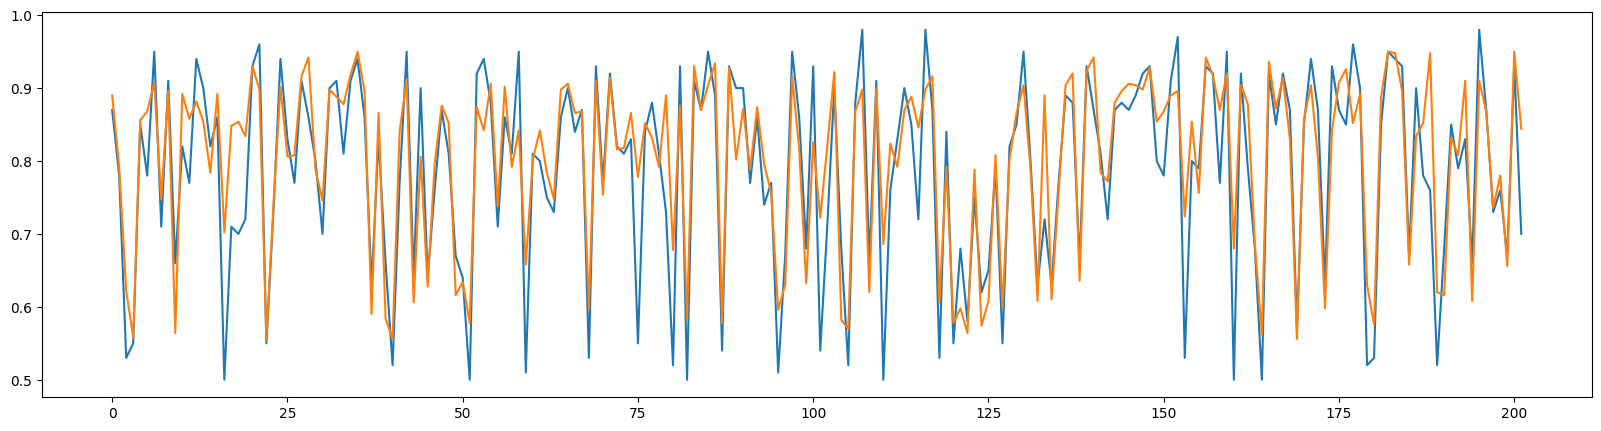

In [9]:
import numpy as np
fig, ax = plt.subplots()
line1 = ax.plot(np.asarray(y_test))
line2 = ax.plot(np.asarray(y_pred))
#line3 = ax.plot(np.sort(100 * abs(np.asarray(y_test) - np.asarray(y_pred))/ np.asarray(y_test)))
plt.show()

In [10]:
from sklearn import neural_network
model = neural_network.MLPRegressor(hidden_layer_sizes=(100), activation='tanh', alpha=0.0001, max_iter=100000).fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('mse: %.3f, mae: %.3f' % (mse ** 0.5, mae))

mse: 0.118, mae: 0.089


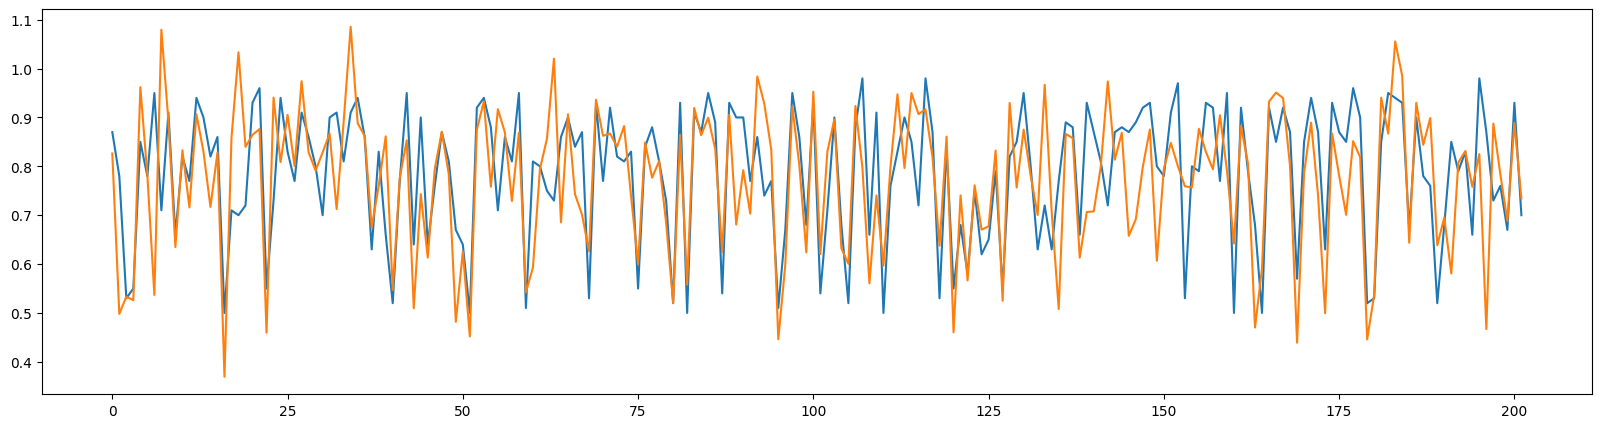

In [11]:
import numpy as np
fig, ax = plt.subplots()
line1 = ax.plot(np.asarray(y_test))
line2 = ax.plot(np.asarray(y_pred))
#line3 = ax.plot(np.sort(100 * abs(np.asarray(y_test) - np.asarray(y_pred))/ np.asarray(y_test)))
plt.show()

In [12]:
from sklearn import svm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Создание и обучение модели SVM
model = svm.SVR(epsilon=0.05)
model.fit(x_train, y_train)

# Получение предсказаний на тестовой выборке
y_pred = model.predict(x_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Вывод результатов
print('mse: %.3f, mae: %.3f' % (mse ** 0.5, mae))

mse: 0.058, mae: 0.046


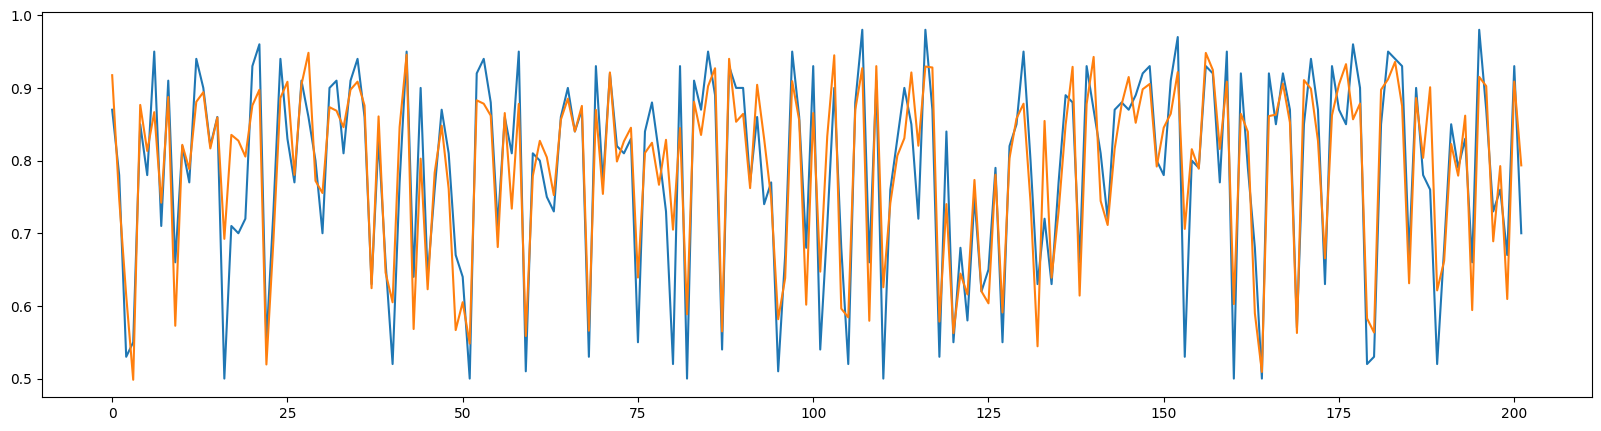

In [13]:
import numpy as np
fig, ax = plt.subplots()
line1 = ax.plot(np.asarray(y_test))
line2 = ax.plot(np.asarray(y_pred))
#line3 = ax.plot(np.sort(100 * abs(np.asarray(y_test) - np.asarray(y_pred))/ np.asarray(y_test)))
plt.show()